# Exploratory Data Analysis and Visualization

In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [4]:
from basic_dataset import BasicDataset

In [5]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData_all'), n_sample=2000)
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData_all'), n_sample=400)
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData_all'), n_sample=400)

train_dataloader = DataLoader(train_dataset, batch_size=2000, num_workers=4, pin_memory=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True)

In [6]:
for batch in train_dataloader:
    sample_batch = batch
    break
lung_train = sample_batch['image'].numpy()
infect_train = sample_batch['mask'].numpy()

for batch in valid_dataloader:
    sample_batch = batch
    break
lung_val = sample_batch['image'].numpy()
infect_val = sample_batch['mask'].numpy()


for batch in test_dataloader:
    sample_batch = batch
    break
lung_test = sample_batch['image'].numpy()
infect_test = sample_batch['mask'].numpy()

<b>Class Imbalance</b>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


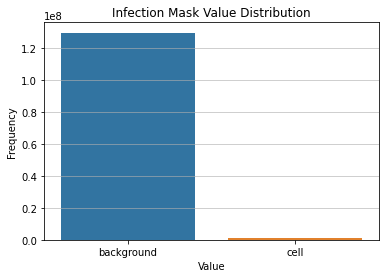

In [10]:
g = sns.countplot(infect_train.flatten())
g.set_xticklabels(['background','cell'])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Infection Mask Value Distribution')
plt.show()

<b>Ratio of Mask</b>

In [17]:
# first validation batch
for batch in valid_dataloader:
    sample_batch = batch
    break
lung_val = sample_batch['image'].numpy()
infect_val = sample_batch['mask'].numpy()

lung_val.mean(), infect_val.mean()

(0.3231307, 0.005931854248046875)

In [30]:
# last validation batch
for batch in valid_dataloader:
    last_batch = batch

lung_val = last_batch['image'].numpy()
infect_val = last_batch['mask'].numpy()

lung_val.mean(), infect_val.mean()

(0.28733003, 0.0063991546630859375)

In [17]:
## mask ratio
# for i in range(300):
#     print(infect_val[i].mean())

infect_train.mean(), infect_val.mean(), infect_test.mean()

(0.010363052368164063, 0.017760721842447917, 0.013676503499348958)

<b> Load Full Datasets </b>

In [5]:
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'))
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'))
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'))
len(train_dataset), len(valid_dataset), len(test_dataset)

(2910, 1467, 1197)

<b> Check Data Shape </b>

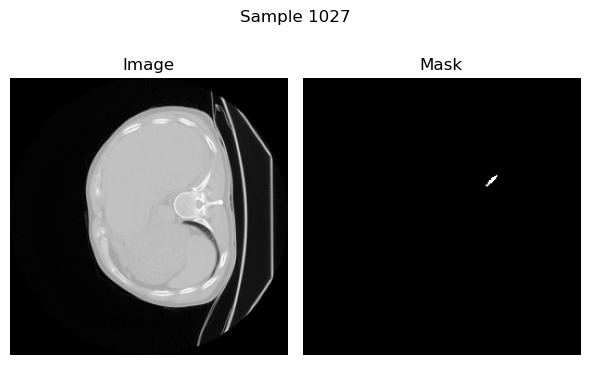

x shape: torch.Size([1, 256, 256])
y shape: torch.Size([256, 256])


In [7]:
from utils import show_pair

# show a random pair (CT image, infection mask)
sample_data = train_dataset[np.random.randint(0, len(train_dataset))]
x, y, idx = sample_data['image'], sample_data['mask'], sample_data['img_id']
show_pair(x[0], y, idx)
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')


In [7]:
# describe image 
pd.DataFrame(x.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.262904
std,0.336328
min,0.000000
25%,0.007843
50%,0.023529
75%,0.721569
max,1.000000


In [8]:
# describe mask
pd.DataFrame(y.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.000549
std,0.023431
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<b> Show Data Split </b>

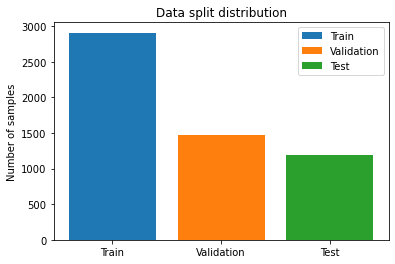

In [9]:
from utils import show_datasets

show_datasets(train_dataset, valid_dataset, test_dataset)